In [21]:
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as anim
import numpy as np
import types
%matplotlib notebook

from scipy.constants.constants import C2K
from scipy.constants.constants import K2C
from scipy.constants.constants import F2K
from scipy.constants.constants import K2F
from scipy.constants.constants import C2F
from scipy.constants.constants import F2C

from Libraries import thermodynamics as thermo

In [2]:
Nx = 51
Ny = 51

x = np.linspace(0,10,Nx)
y = np.linspace(0,5,Ny)

X,Y = np.meshgrid(x,y)

Dx = x[1]-x[0]
Dy = y[1]-y[0]

Dt = .08
nit = 50

T_o = 300.

air = thermo.FluidArray((Ny,Nx))
air.Fluid('air')
air.get_properties(np.full((Ny,Nx),T_o))

Beta = air.beta
Alpha = air.alpha
Mu = air.mu
Rho = air.rho

#alpha = 70./1e6
g = 9.8

#rho_ref = 1.0
#T_ref = 

T_bottom = 320
T_top = 280



In [54]:
"""
Y boundary conditions are isothermal

x boundary condition is continuous (periodic? pacman?)

^ y
|
|
+----> x"""

def BuildPressB(dt,dx,dy,u,v):
    b = np.zeros_like(u)
    b[1:-1,1:-1] = 1/dt*((u[1:-1,2:]-u[1:-1,:-2])/(2*dx)+(v[2:,1:-1]-v[:-2,1:-1])/(2*dy)) - \
                ((u[1:-1,2:]-u[1:-1,:-2])/(2*dx))**2 - 2*(u[2:,1:-1]-u[:-2,1:-1])/(2*dy)*(v[1:-1,2:]-v[1:-1,:-2])/(2*dy) - \
                ((v[2:,1:-1]-v[:-2,1:-1])/(2*dy))**2
    b[1:-1,0] = 1/dt*((u[1:-1,1]-u[1:-1,-1])/(2*dx)+(v[2:,0]-v[:-2,0])/(2*dy)) - ((u[1:-1,1]-u[1:-1,-1])/(2*dx))**2 - \
                    2*((u[2:,0]-u[:-2,0])/(2*dy)*(v[1:-1,1]-v[1:-1,-1])/(2*dx)) - ((v[2:,0]-v[:-2,0])/(2*dy))**2
    b[1:-1,-1] = 1/dt*((u[1:-1,0]-u[1:-1,-2])/(2*dx)+(v[2:,-1]-v[:-2,-1])/(2*dy)) - ((u[1:-1,0]-u[1:-1,-2])/(2*dx))**2 - \
                    2*((u[2:,-1]-u[:-2,-1])/(2*dy)*(v[1:-1,0]-v[1:-1,-2])/(2*dx)) - ((v[2:,-1]-v[:-2,-1])/(2*dy))**2
    return b

def PressEqn(P,dx,dy,rho,b):
    global nit
    Pn = np.empty_like(P)
    
    for q in range(nit):
        Pn = P.copy()
        
        P[1:-1,1:-1] = ((Pn[1:-1,2:]+Pn[1:-1,:-2])*dy**2+(Pn[2:,1:-1]+Pn[:-2,1:-1])*dx**2)/(2*(dx**2+dy**2)) - \
                        (rho[1:-1,1:-1]*dx**2*dy**2)/(2*(dx**2+dy**2))*b[1:-1,1:-1]
        
        P[1:-1,0] = ((Pn[1:-1,1]+Pn[1:-1,-1])*dy**2+(Pn[2:,0]+Pn[:-2,0])*dx**2)/(2*(dx**2+dy**2)) - \
                        (rho[1:-1,0]*dx**2*dy**2)/(2*(dx**2+dy**2))*b[1:-1,0]
        
        P[1:-1,-1] = ((Pn[1:-1,0]+Pn[1:-1,-2])*dy**2+(Pn[2:,-1]+Pn[:-2,-1])*dx**2)/(2*(dx**2+dy**2)) - \
                        (rho[1:-1,-1]*dx**2*dy**2)/(2*(dx**2+dy**2))*b[1:-1,-1]
        
        P[-1,:] = P[-2,:]
        P[0,:] = P[1,:]
        
    return P

def Step(steps,mid_temp,P_o,dx,dy,dt,T_b,T_t,nx,ny, alpha,beta, mu, rho):
    global air, g #rho_ref, T_ref
    
    P = np.full((ny,nx),P_o)
    T = np.full((ny,nx), mid_temp)
    u = np.full((ny,nx),0.1)
    v = np.zeros((ny,nx))
    B = np.zeros((ny,nx))
    
    T_ref = mid_temp
    
    count = 0
    while count<steps:
        un = u.copy()
        vn = v.copy()
        Tn = T.copy()
        
        air.get_properties(Tn)
        beta = air.beta
        alpha = air.alpha
        mu = air.mu
        rho = air.rho
        
        #b = BuildPressB(dt,dx,dy,u,v)
        #P = PressEqn(P,dx,dy,rho,b)
        #Pn = P.copy()
        
        #z = nx-1
        #q = ny-1
        
        T[1:-1,1:-1] = (Tn[1:-1,1:-1]*dx**2*dy**2 + dt*un[1:-1,1:-1]*dx*dy**2*(-Tn[1:-1,2:] + Tn[1:-1,:-2]) + \
                        dt*dx**2*vn[1:-1,1:-1]*dy*(-Tn[2:,1:-1] + Tn[:-2,1:-1]) + dt*dx**2*alpha[1:-1,1:-1]*(-2*Tn[1:-1,1:-1] + \
                        Tn[2:,1:-1] + Tn[:-2,1:-1]) + dt*dy**2*alpha[1:-1,1:-1]*(-2*Tn[1:-1,1:-1] + Tn[1:-1,2:] + \
                                                                                 Tn[1:-1,:-2]))/(dx**2*dy**2)
        
        T[0,1:-1] = (Tn[0,1:-1]*dx**2*dy**2 + dt*un[0,1:-1]*dx*dy**2*(-Tn[0,2:] + Tn[0,:-2]) + \
                     dt*dx**2*vn[0,1:-1]*dy*(-Tn[1,1:-1] + T_b) + dt*dx**2*alpha[0,1:-1]*(-2*Tn[0,1:-1] + Tn[1,1:-1] + T_b) + \
                     dt*dy**2*alpha[0,1:-1]*(-2*Tn[0,1:-1] + Tn[0,2:] + Tn[0,:-2]))/(dx**2*dy**2)
        T[-1,1:-1] = (Tn[-1,1:-1]*dx**2*dy**2 + dt*un[-1,1:-1]*dx*dy**2*(-Tn[-1,2:] + Tn[-1,:-2]) + \
                      dt*dx**2*vn[-1,1:-1]*dy*(-T_t + Tn[-2,1:-1]) + dt*dx**2*alpha[-1,1:-1]*(-2*Tn[-1,1:-1] + T_t + \
                      Tn[-2,1:-1]) + dt*dy**2*alpha[-1,1:-1]*(-2*Tn[-1,1:-1] + Tn[-1,2:] + Tn[-1,:-2]))/(dx**2*dy**2)
        T[1:-1,0] = (Tn[1:-1,0]*dx**2*dy**2 + dt*un[1:-1,0]*dx*dy**2*(-Tn[1:-1,1] + Tn[1:-1,-1]) + \
                     dt*dx**2*vn[1:-1,0]*dy*(-Tn[2:,0] + Tn[:-2,0]) + dt*dx**2*alpha[1:-1,0]*(-2*Tn[1:-1,0] + Tn[2:,0] + \
                     Tn[:-2,0]) + dt*dy**2*alpha[1:-1,0]*(-2*Tn[1:-1,0] + Tn[1:-1,1] + Tn[1:-1,-1]))/(dx**2*dy**2)
        T[1:-1,-1] = (Tn[1:-1,-1]*dx**2*dy**2 + dt*un[1:-1,-1]*dx*dy**2*(-Tn[1:-1,0] + Tn[1:-1,-2]) + \
                      dt*dx**2*vn[1:-1,-1]*dy*(-Tn[2:,-1] + Tn[:-2,-1]) + dt*dx**2*alpha[1:-1,-1]*(-2*Tn[1:-1,-1] + Tn[2:,-1] + \
                      Tn[:-2,-1]) + dt*dy**2*alpha[1:-1,-1]*(-2*Tn[1:-1,-1] + Tn[1:-1,0] + Tn[1:-1,-2]))/(dx**2*dy**2)
        
        T[0,0] = (Tn[0,0]*dx**2*dy**2 + dt*un[0,0]*dx*dy**2*(-Tn[0,1] + Tn[0,-1]) + dt*dx**2*vn[0,0]*dy*(-Tn[1,0] + T_b) + \
                  dt*dx**2*alpha[0,0]*(-2*Tn[0,0] + Tn[1,0] + T_b) + dt*dy**2*alpha[0,0]*(-2*Tn[0,0] + Tn[0,1] + 
                                                                                            Tn[0,-1]))/(dx**2*dy**2)
        T[0,-1] = (Tn[0,-1]*dx**2*dy**2 + dt*un[0,-1]*dx*dy**2*(-Tn[0,0] + Tn[0,-2]) + dt*dx**2*vn[0,-1]*dy*(-Tn[1,-1] + T_b) + \
                   dt*dx**2*alpha[0,-1]*(-2*Tn[0,-1] + Tn[1,-1] + T_b) + dt*dy**2*alpha[0,-1]*(-2*Tn[0,-1] + Tn[0,0] + \
                                                                                               Tn[0,-2]))/(dx**2*dy**2)
        T[-1,0] = (Tn[-1,0]*dx**2*dy**2 + dt*un[-1,0]*dx*dy**2*(-Tn[-1,1] + Tn[-1,-1]) + dt*dx**2*vn[-1,0]*dy*(-T_t + Tn[-2,0])+\
                   dt*dx**2*alpha[-1,0]*(-2*Tn[-1,0] + T_t + Tn[-2,0]) + dt*dy**2*alpha[-1,0]*(-2*Tn[-1,0] + Tn[-1,1] + \
                                                                                               Tn[-1,-1]))/(dx**2*dy**2)
        T[-1,-1] = (Tn[-1,-1]*dx**2*dy**2 + dt*un[-1,-1]*dx*dy**2*(-Tn[-1,0] + Tn[-1,-2]) + dt*dx**2*vn[-1,-1]*dy*(-T_t + \
                    Tn[-2,-1]) + dt*dx**2*alpha[-1,-1]*(-2*Tn[-1,-1] + T_t + Tn[-2,-1]) + dt*dy**2*alpha[-1,-1]*(-2*Tn[-1,-1] + \
                    Tn[-1,0] + Tn[-1,-2]))/(dx**2*dy**2)
        
        u[1:-1,1:-1] = (rho[1:-1,1:-1]*un[1:-1,1:-1]*dt*dx*dy**2*(-un[1:-1,2:] + un[1:-1,:-2])/2 + \
                        rho[1:-1,1:-1]*un[1:-1,1:-1]*dx**2*dy**2 + rho[1:-1,1:-1]*dt*dx**2*vn[1:-1,1:-1]*dy*(-un[2:,1:-1] + \
                        un[:-2,1:-1])/2 + dt*dx**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[2:,1:-1] + un[:-2,1:-1]) + \
                        dt*dy**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[1:-1,2:] + un[1:-1,:-2]))/(rho[1:-1,1:-1]*dx**2*dy**2)
        
        u[0,1:-1] = (rho[0,1:-1]*un[0,1:-1]*dt*dx*dy**2*(-un[0,2:] + un[0,:-2])/2 + rho[0,1:-1]*un[0,1:-1]*dx**2*dy**2 + \
                     rho[0,1:-1]*dt*dx**2*vn[0,1:-1]*dy*(-un[1,1:-1] + 0)/2 + dt*dx**2*mu[0,1:-1]*(-2*un[0,1:-1] + un[1,1:-1]+0)\
                     + dt*dy**2*mu[0,1:-1]*(-2*un[0,1:-1] + un[0,2:] + un[0,:-2]))/(rho[0,1:-1]*dx**2*dy**2)
        u[-1,1:-1] = (rho[-1,1:-1]*un[-1,1:-1]*dt*dx*dy**2*(-un[-1,2:] + un[-1,:-2])/2 + rho[-1,1:-1]*un[-1,1:-1]*dx**2*dy**2 + \
                      rho[-1,1:-1]*dt*dx**2*vn[-1,1:-1]*dy*(-0 + un[-2,1:-1])/2 + dt*dx**2*mu[-1,1:-1]*(-2*un[-1,1:-1] + 0 + \
                      un[-2,1:-1]) + dt*dy**2*mu[-1,1:-1]*(-2*un[-1,1:-1] + un[-1,2:] + un[-1,:-2]))/(rho[-1,1:-1]*dx**2*dy**2)
        u[1:-1,0] = (rho[1:-1,0]*un[1:-1,0]*dt*dx*dy**2*(-un[1:-1,1] + un[1:-1,-1])/2 + rho[1:-1,0]*un[1:-1,0]*dx**2*dy**2 + \
                     rho[1:-1,0]*dt*dx**2*vn[1:-1,0]*dy*(-un[2:,0] + un[:-2,0])/2 + dt*dx**2*mu[1:-1,0]*(-2*un[1:-1,0] + \
                     un[2:,0] + un[:-2,0]) + dt*dy**2*mu[1:-1,0]*(-2*un[1:-1,0] + un[1:-1,1] + \
                                                                  un[1:-1,-1]))/(rho[1:-1,0]*dx**2*dy**2)
        u[1:-1,-1] = (rho[1:-1,-1]*un[1:-1,-1]*dt*dx*dy**2*(-un[1:-1,0] + un[1:-1,-2])/2 + \
                      rho[1:-1,-1]*un[1:-1,-1]*dx**2*dy**2 + rho[1:-1,-1]*dt*dx**2*vn[1:-1,-1]*dy*(-un[2:,-1] + un[:-2,-1])/2 +\
                      dt*dx**2*mu[1:-1,-1]*(-2*un[1:-1,-1] + un[2:,-1] + un[:-2,-1]) + dt*dy**2*mu[1:-1,-1]*(-2*un[1:-1,-1] + \
                      un[1:-1,0] + un[1:-1,-2]))/(rho[1:-1,-1]*dx**2*dy**2)
        
        u[0,0] = (rho[0,0]*un[0,0]*dt*dx*dy**2*(-un[0,1] + un[0,-1])/2 + rho[0,0]*un[0,0]*dx**2*dy**2 + \
                  rho[0,0]*dt*dx**2*vn[0,0]*dy*(-un[1,0] + 0)/2 + dt*dx**2*mu[0,0]*(-2*un[0,0] + un[1,0] + 0) + \
                  dt*dy**2*mu[0,0]*(-2*un[0,0] + un[0,1] + un[0,-1]))/(rho[0,0]*dx**2*dy**2)
        u[0,-1] = (rho[0,-1]*un[0,-1]*dt*dx*dy**2*(-un[0,0] + un[0,-2])/2 + rho[0,-1]*un[0,-1]*dx**2*dy**2 + \
                   rho[0,-1]*dt*dx**2*vn[0,-1]*dy*(-un[1,-1] + 0)/2 + dt*dx**2*mu[0,-1]*(-2*un[0,-1] + un[1,-1] + 0) + \
                   dt*dy**2*mu[0,-1]*(-2*un[0,-1] + un[0,0] + un[0,-2]))/(rho[0,-1]*dx**2*dy**2)
        u[-1,-1] = (rho[-1,-1]*un[-1,-1]*dt*dx*dy**2*(-un[-1,0] + un[-1,-2])/2 + rho[-1,-1]*un[-1,-1]*dx**2*dy**2 + \
                    rho[-1,-1]*dt*dx**2*vn[-1,-1]*dy*(-0 + un[-2,-1])/2 + dt*dx**2*mu[-1,-1]*(-2*un[-1,-1] + 0 + un[-2,-1]) + \
                    dt*dy**2*mu[-1,-1]*(-2*un[-1,-1] + un[-1,0] + un[-1,-2]))/(rho[-1,-1]*dx**2*dy**2)
        u[-1,0] = (rho[-1,0]*un[-1,0]*dt*dx*dy**2*(-un[-1,1] + un[-1,-1])/2 + rho[-1,0]*un[-1,0]*dx**2*dy**2 + \
                   rho[-1,0]*dt*dx**2*vn[-1,0]*dy*(-0 + un[-2,0])/2 + dt*dx**2*mu[-1,0]*(-2*un[-1,0] + 0 + un[-2,0]) + \
                   dt*dy**2*mu[-1,0]*(-2*un[-1,0] + un[-1,1] + un[-1,-1]))/(rho[-1,0]*dx**2*dy**2)
        
        """u[1:-1,1:-1] = (rho[1:-1,1:-1]*un[1:-1,1:-1]*dy**2*dx**2 + rho[1:-1,1:-1]*dt*dy*dx**2*(un[1:-1,1:-1]*vn[1:-1,2:] - \
                        un[1:-1,1:-1]*vn[1:-1,:-2] - vn[1:-1,1:-1]*un[2:,1:-1] + vn[1:-1,1:-1]*un[:-2,1:-1])/2 + \
                        dt*dy**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[1:-1,:-2] + un[1:-1,2:]) + \
                        dt*mu[1:-1,1:-1]*dx**2*(-2*un[1:-1,1:-1] + un[2:,1:-1] + un[:-2,1:-1]))/(rho[1:-1,1:-1]*dy**2*dx**2)
        
        u[0,1:-1] = (rho[0,1:-1]*un[0,1:-1]*dy**2*dx**2 + rho[0,1:-1]*dt*dy*dx**2*(un[0,1:-1]*vn[0,2:] - un[0,1:-1]*vn[0,:-2] -\
                     vn[0,1:-1]*un[1,1:-1] + vn[0,1:-1]*0)/2 + dt*dy**2*mu[0,1:-1]*(-2*un[0,1:-1] + un[0,:-2] + un[0,2:]) + \
                     dt*mu[0,1:-1]*dx**2*(-2*un[0,1:-1] + un[1,1:-1] + 0))/(rho[0,1:-1]*dy**2*dx**2)
        u[-1,1:-1] = (rho[-1,1:-1]*un[-1,1:-1]*dy**2*dx**2 + rho[-1,1:-1]*dt*dy*dx**2*(un[-1,1:-1]*vn[-1,2:] - \
                      un[-1,1:-1]*vn[-1,:-2] - vn[-1,1:-1]*0 + vn[-1,1:-1]*un[-2,1:-1])/2 +dt*dy**2*mu[-1,1:-1]*(-2*un[-1,1:-1]+\
                      un[-1,:-2] + un[-1,2:]) + dt*mu[-1,1:-1]*dx**2*(-2*un[-1,1:-1] + 0 + \
                                                                      un[-2,1:-1]))/(rho[-1,1:-1]*dy**2*dx**2)
        u[1:-1,-1] = (rho[1:-1,-1]*un[1:-1,-1]*dy**2*dx**2 + rho[1:-1,-1]*dt*dy*dx**2*(un[1:-1,-1]*vn[1:-1,0] - \
                      un[1:-1,-1]*vn[1:-1,-2] - vn[1:-1,-1]*un[2:,-1] + vn[1:-1,-1]*un[:-2,-1])/2 + \
                      dt*dy**2*mu[1:-1,-1]*(-2*un[1:-1,-1] + un[1:-1,-2] + un[1:-1,0]) + dt*mu[1:-1,-1]*dx**2*(-2*un[1:-1,-1] + \
                      un[2:,-1] + un[:-2,-1]))/(rho[1:-1,-1]*dy**2*dx**2)
        u[1:-1,0] = (rho[1:-1,0]*un[1:-1,0]*dy**2*dx**2 + rho[1:-1,0]*dt*dy*dx**2*(un[1:-1,0]*vn[1:-1,1] - \
                      un[1:-1,0]*vn[1:-1,-1] - vn[1:-1,0]*un[2:,0] + vn[1:-1,0]*un[:-2,0])/2 + \
                      dt*dy**2*mu[1:-1,0]*(-2*un[1:-1,0] + un[1:-1,-1] + un[1:-1,1]) + dt*mu[1:-1,0]*dx**2*(-2*un[1:-1,0] + \
                      un[2:,0] + un[:-2,0]))/(rho[1:-1,0]*dy**2*dx**2)
        
        u[0,0] = (rho[0,0]*un[0,0]*dy**2*dx**2 + rho[0,0]*dt*dy*dx**2*(un[0,0]*vn[0,1] - un[0,0]*vn[0,-1] - vn[0,0]*un[1,0] + \
                  vn[0,0]*0)/2 + dt*dy**2*mu[0,0]*(-2*un[0,0] + un[0,-1] + un[0,1]) + dt*mu[0,0]*dx**2*(-2*un[0,0] + \
                                                                                        un[1,0] + 0))/(rho[0,0]*dy**2*dx**2)
        u[-1,0] = (rho[-1,0]*un[-1,0]*dy**2*dx**2 + rho[-1,0]*dt*dy*dx**2*(un[-1,0]*vn[-1,1] - un[-1,0]*vn[-1,-1] - \
                   vn[-1,0]*0 + vn[-1,0]*un[-2,0])/2 + dt*dy**2*mu[-1,0]*(-2*un[-1,0] + un[-1,-1] + un[-1,1]) + \
                   dt*mu[-1,0]*dx**2*(-2*un[-1,0] + 0 + un[-2,0]))/(rho[-1,0]*dy**2*dx**2)
        u[-1,-1] = (rho[-1,-1]*un[-1,-1]*dy**2*dx**2 + rho[-1,-1]*dt*dy*dx**2*(un[-1,-1]*vn[-1,0] - un[-1,-1]*vn[-1,-2] - \
                    vn[-1,-1]*0 + vn[-1,-1]*un[-2,-1])/2 + dt*dy**2*mu[-1,-1]*(-2*un[-1,-1] + un[-1,-2] + un[-1,0]) + \
                    dt*mu[-1,-1]*dx**2*(-2*un[-1,-1] + 0 + un[-2,-1]))/(rho[-1,-1]*dy**2*dx**2)
        u[0,-1] = (rho[0,-1]*un[0,-1]*dy**2*dx**2 + rho[0,-1]*dt*dy*dx**2*(un[0,-1]*vn[0,0] - un[0,-1]*vn[0,-2] - \
                   vn[0,-1]*un[1,-1] + vn[0,-1]*0)/2 + dt*dy**2*mu[0,-1]*(-2*un[0,-1] + un[0,-2] + un[0,0]) + \
                   dt*mu[0,-1]*dx**2*(-2*un[0,-1] + un[1,-1] + 0))/(rho[0,-1]*dy**2*dx**2)"""
        
        v[1:-1,1:-1] = (rho[1:-1,1:-1]*vn[1:-1,1:-1]*dt*dx**2*dy*(-vn[2:,1:-1] + vn[:-2,1:-1])/2 + \
                        rho[1:-1,1:-1]*dt*un[1:-1,1:-1]*dx*dy**2*(-vn[1:-1,2:] + vn[1:-1,:-2])/2 + \
                        rho[1:-1,1:-1]*dx**2*dy**2*(vn[1:-1,1:-1] + dt*g*beta[1:-1,1:-1]*Tn[1:-1,1:-1] - \
                        dt*g*beta[1:-1,1:-1]*T_ref) + dt*dx**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + vn[2:,1:-1] + vn[:-2,1:-1]) + \
                        dt*dy**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + vn[1:-1,2:] + vn[1:-1,:-2]))/(rho[1:-1,1:-1]*dx**2*dy**2)
        
        v[0,1:-1] = (rho[0,1:-1]*vn[0,1:-1]*dt*dx**2*dy*(-vn[1,1:-1] + 0)/2 + rho[0,1:-1]*dt*un[0,1:-1]*dx*dy**2*(-vn[0,2:] + \
                     vn[0,:-2])/2 + rho[0,1:-1]*dx**2*dy**2*(vn[0,1:-1] + dt*g*beta[0,1:-1]*Tn[0,1:-1] - \
                     dt*g*beta[0,1:-1]*T_ref) + dt*dx**2*mu[0,1:-1]*(-2*vn[0,1:-1] + vn[1,1:-1] + 0) + \
                     dt*dy**2*mu[0,1:-1]*(-2*vn[0,1:-1] + vn[0,2:] + vn[0,:-2]))/(rho[0,1:-1]*dx**2*dy**2)
        v[-1,1:-1] = (rho[-1,1:-1]*vn[-1,1:-1]*dt*dx**2*dy*(-0 + vn[-2,1:-1])/2 + rho[-1,1:-1]*dt*un[-1,1:-1]*dx*dy**2*\
                      (-vn[-1,2:] + vn[-1,:-2])/2 + rho[-1,1:-1]*dx**2*dy**2*(vn[-1,1:-1] + dt*g*beta[-1,1:-1]*Tn[-1,1:-1] - \
                      dt*g*beta[-1,1:-1]*T_ref) + dt*dx**2*mu[-1,1:-1]*(-2*vn[-1,1:-1] + 0 + vn[-2,1:-1]) + \
                      dt*dy**2*mu[-1,1:-1]*(-2*vn[-1,1:-1] + vn[-1,2:] + vn[-1,:-2]))/(rho[-1,1:-1]*dx**2*dy**2)
        v[1:-1,0] = (rho[1:-1,0]*vn[1:-1,0]*dt*dx**2*dy*(-vn[2:,0] + vn[:-2,0])/2 + rho[1:-1,0]*dt*un[1:-1,0]*dx*dy**2*\
                     (-vn[1:-1,1] + vn[1:-1,-1])/2 + rho[1:-1,0]*dx**2*dy**2*(vn[1:-1,0] + dt*g*beta[1:-1,0]*Tn[1:-1,0] - \
                     dt*g*beta[1:-1,0]*T_ref) + dt*dx**2*mu[1:-1,0]*(-2*vn[1:-1,0] + vn[2:,0] + vn[:-2,0]) + \
                     dt*dy**2*mu[1:-1,0]*(-2*vn[1:-1,0] + vn[1:-1,1] + vn[1:-1,-1]))/(rho[1:-1,0]*dx**2*dy**2)
        v[1:-1,-1] = (rho[1:-1,-1]*vn[1:-1,-1]*dt*dx**2*dy*(-vn[2:,-1] + vn[:-2,-1])/2 + rho[1:-1,-1]*dt*un[1:-1,-1]*dx*dy**2*\
                      (-vn[1:-1,0] + vn[1:-1,-2])/2 + rho[1:-1,-1]*dx**2*dy**2*(vn[1:-1,-1] + dt*g*beta[1:-1,-1]*Tn[1:-1,-1] - \
                      dt*g*beta[1:-1,-1]*T_ref) + dt*dx**2*mu[1:-1,-1]*(-2*vn[1:-1,-1] + vn[2:,-1] + vn[:-2,-1]) + \
                      dt*dy**2*mu[1:-1,-1]*(-2*vn[1:-1,-1] + vn[1:-1,0] + vn[1:-1,-2]))/(rho[1:-1,-1]*dx**2*dy**2)
        
        v[0,0] = (rho[0,0]*vn[0,0]*dt*dx**2*dy*(-vn[1,0] + 0)/2 + rho[0,0]*dt*un[0,0]*dx*dy**2*(-vn[0,1] + vn[0,-1])/2 + \
                  rho[0,0]*dx**2*dy**2*(vn[0,0] + dt*g*beta[0,0]*Tn[0,0] - dt*g*beta[0,0]*T_ref) + dt*dx**2*mu[0,0]*(-2*vn[0,0]\
                  + vn[1,0] + 0) + dt*dy**2*mu[0,0]*(-2*vn[0,0] + vn[0,1] + vn[0,-1]))/(rho[0,0]*dx**2*dy**2)
        v[0,-1] = (rho[0,-1]*vn[0,-1]*dt*dx**2*dy*(-vn[1,-1] + 0)/2 + rho[0,-1]*dt*un[0,-1]*dx*dy**2*(-vn[0,0] + vn[0,-2])/2 + \
                   rho[0,-1]*dx**2*dy**2*(vn[0,-1] + dt*g*beta[0,-1]*Tn[0,-1] - dt*g*beta[0,-1]*T_ref) + \
                   dt*dx**2*mu[0,-1]*(-2*vn[0,-1] + vn[1,-1] + 0) + dt*dy**2*mu[0,-1]*(-2*vn[0,-1] + vn[0,0] + \
                                                                                       vn[0,-2]))/(rho[0,-1]*dx**2*dy**2)
        v[-1,-1] = (rho[-1,-1]*vn[-1,-1]*dt*dx**2*dy*(-0 + vn[-2,-1])/2 + rho[-1,-1]*dt*un[-1,-1]*dx*dy**2*(-vn[-1,0] + \
                    vn[-1,-2])/2 + rho[-1,-1]*dx**2*dy**2*(vn[-1,-1] + dt*g*beta[-1,-1]*Tn[-1,-1] - dt*g*beta[-1,-1]*T_ref) + \
                    dt*dx**2*mu[-1,-1]*(-2*vn[-1,-1] + 0 + vn[-2,-1]) + dt*dy**2*mu[-1,-1]*(-2*vn[-1,-1] + vn[-1,0] + \
                                                                                            vn[-1,-2]))/(rho[-1,-1]*dx**2*dy**2)
        v[-1,0] = (rho[-1,0]*vn[-1,0]*dt*dx**2*dy*(-0 + vn[-2,0])/2 + rho[-1,0]*dt*un[-1,0]*dx*dy**2*(-vn[-1,1] + vn[-1,-1])/2+\
                   rho[-1,0]*dx**2*dy**2*(vn[-1,0] + dt*g*beta[-1,0]*Tn[-1,0] - dt*g*beta[-1,0]*T_ref) + \
                   dt*dx**2*mu[-1,0]*(-2*vn[-1,0] + 0 + vn[-2,0]) + dt*dy**2*mu[-1,0]*(-2*vn[-1,0] + vn[-1,1] + \
                                                                                       vn[-1,-1]))/(rho[-1,0]*dx**2*dy**2)
        
        count += 1
        
    return u,v,T
    #return T

In [ ]:
fig = pl.figure()
pl.contourf(X,Y,P)
pl.colorbar()
pl.axes().set_aspect('equal')

<IPython.core.display.Javascript object>


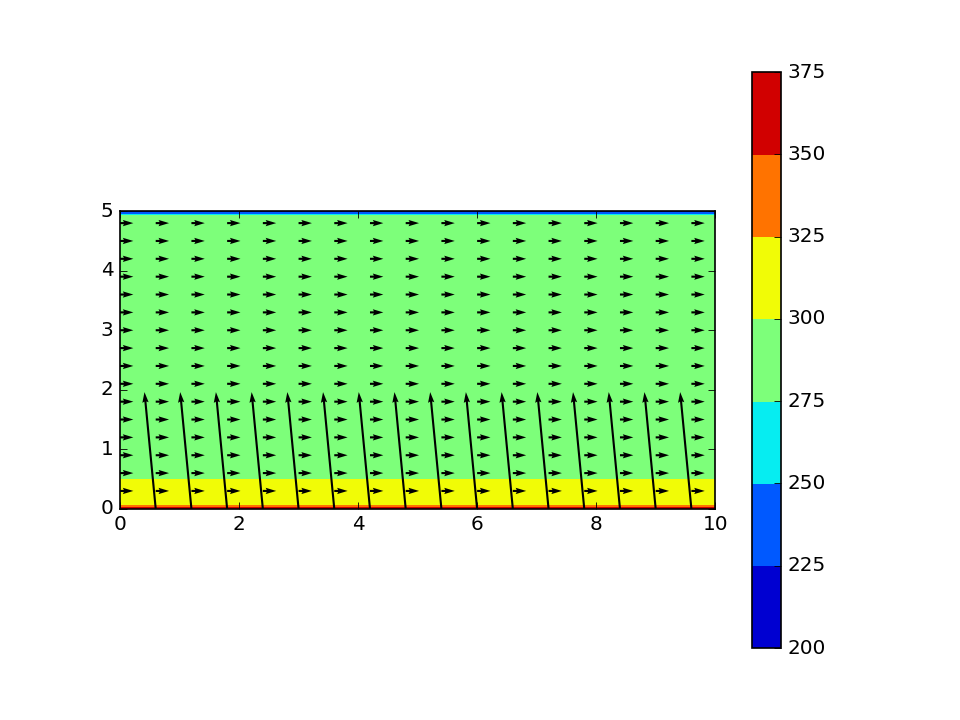

In [55]:
#              steps,mid_temp,P_o,dx,dy,dt,T_b,T_t,nx,ny, beta, mu, rho
Dt = 0.1
U,V,T = Step(40,T_o,1.,Dx,Dy,Dt,T_bottom,T_top,Nx,Ny, Alpha, Beta, Mu, Rho)
fig = pl.figure(dpi=120)
#pl.pcolormesh(X,Y,T)
pl.contourf(X,Y,T)
pl.colorbar()
pl.quiver(X[::3, ::3],Y[::3, ::3],U[::3, ::3],V[::3, ::3])
pl.axes().set_aspect('equal')

In [59]:
T[:,0]

array([ 373.20454699,  300.5582503 ,  300.00019657,  300.00000009,
        300.        ,  300.        ,  300.        ,  300.        ,
        300.        ,  300.        ,  300.        ,  300.        ,
        300.        ,  300.        ,  300.        ,  300.        ,
        300.        ,  300.        ,  300.        ,  300.        ,
        300.        ,  300.        ,  300.        ,  300.        ,
        300.        ,  300.        ,  300.        ,  300.        ,
        300.        ,  300.        ,  300.        ,  300.        ,
        300.        ,  300.        ,  300.        ,  300.        ,
        300.        ,  300.        ,  300.        ,  300.        ,
        300.        ,  300.        ,  300.        ,  300.        ,
        300.        ,  300.        ,  300.        ,  299.9999999 ,
        299.99978765,  299.34131021,  216.76994759])

In [38]:
def AnimStep(steps,mid_temp,P_o,dx,dy,dt,T_b,T_t,nx,ny):
    global air, g #rho_ref, T_ref
    global X,Y
    
    P = np.full((ny,nx),P_o)
    T = np.full((ny,nx), mid_temp)
    u = np.zeros((ny,nx))
    v = np.zeros((ny,nx))
    B = np.zeros((ny,nx))
    
    T_ref = mid_temp
    
    ims = []
    
    count = 0
    while count<steps:
        un = u.copy()
        vn = v.copy()
        Tn = T.copy()
        
        air.get_properties(Tn)
        beta = air.beta
        alpha = air.alpha
        mu = air.mu
        rho = air.rho
        
        #b = BuildPressB(dt,dx,dy,u,v)
        #P = PressEqn(P,dx,dy,rho,b)
        #Pn = P.copy()
        
        #z = nx-1
        #q = ny-1
        
        T[1:-1,1:-1] = (Tn[1:-1,1:-1]*dx**2*dy**2 + dt*un[1:-1,1:-1]*dx*dy**2*(-Tn[1:-1,2:] + Tn[1:-1,:-2]) + \
                        dt*dx**2*vn[1:-1,1:-1]*dy*(-Tn[2:,1:-1] + Tn[:-2,1:-1]) + dt*dx**2*alpha[1:-1,1:-1]*(-2*Tn[1:-1,1:-1] + \
                        Tn[2:,1:-1] + Tn[:-2,1:-1]) + dt*dy**2*alpha[1:-1,1:-1]*(-2*Tn[1:-1,1:-1] + Tn[1:-1,2:] + \
                                                                                 Tn[1:-1,:-2]))/(dx**2*dy**2)
        
        T[0,1:-1] = (Tn[0,1:-1]*dx**2*dy**2 + dt*un[0,1:-1]*dx*dy**2*(-Tn[0,2:] + Tn[0,:-2]) + \
                     dt*dx**2*vn[0,1:-1]*dy*(-Tn[1,1:-1] + T_b) + dt*dx**2*alpha[0,1:-1]*(-2*Tn[0,1:-1] + Tn[1,1:-1] + T_b) + \
                     dt*dy**2*alpha[0,1:-1]*(-2*Tn[0,1:-1] + Tn[0,2:] + Tn[0,:-2]))/(dx**2*dy**2)
        T[-1,1:-1] = (Tn[-1,1:-1]*dx**2*dy**2 + dt*un[-1,1:-1]*dx*dy**2*(-Tn[-1,2:] + Tn[-1,:-2]) + \
                      dt*dx**2*vn[-1,1:-1]*dy*(-T_t + Tn[-2,1:-1]) + dt*dx**2*alpha[-1,1:-1]*(-2*Tn[-1,1:-1] + T_t + \
                      Tn[-2,1:-1]) + dt*dy**2*alpha[-1,1:-1]*(-2*Tn[-1,1:-1] + Tn[-1,2:] + Tn[-1,:-2]))/(dx**2*dy**2)
        T[1:-1,0] = (Tn[1:-1,0]*dx**2*dy**2 + dt*un[1:-1,0]*dx*dy**2*(-Tn[1:-1,1] + Tn[1:-1,-1]) + \
                     dt*dx**2*vn[1:-1,0]*dy*(-Tn[2:,0] + Tn[:-2,0]) + dt*dx**2*alpha[1:-1,0]*(-2*Tn[1:-1,0] + Tn[2:,0] + \
                     Tn[:-2,0]) + dt*dy**2*alpha[1:-1,0]*(-2*Tn[1:-1,0] + Tn[1:-1,1] + Tn[1:-1,-1]))/(dx**2*dy**2)
        T[1:-1,-1] = (Tn[1:-1,-1]*dx**2*dy**2 + dt*un[1:-1,-1]*dx*dy**2*(-Tn[1:-1,0] + Tn[1:-1,-2]) + \
                      dt*dx**2*vn[1:-1,-1]*dy*(-Tn[2:,-1] + Tn[:-2,-1]) + dt*dx**2*alpha[1:-1,-1]*(-2*Tn[1:-1,-1] + Tn[2:,-1] + \
                      Tn[:-2,-1]) + dt*dy**2*alpha[1:-1,-1]*(-2*Tn[1:-1,-1] + Tn[1:-1,0] + Tn[1:-1,-2]))/(dx**2*dy**2)
        
        T[0,0] = (Tn[0,0]*dx**2*dy**2 + dt*un[0,0]*dx*dy**2*(-Tn[0,1] + Tn[0,-1]) + dt*dx**2*vn[0,0]*dy*(-Tn[1,0] + T_b) + \
                  dt*dx**2*alpha[0,0]*(-2*Tn[0,0] + Tn[1,0] + T_b) + dt*dy**2*alpha[0,0]*(-2*Tn[0,0] + Tn[0,1] + 
                                                                                            Tn[0,-1]))/(dx**2*dy**2)
        T[0,-1] = (Tn[0,-1]*dx**2*dy**2 + dt*un[0,-1]*dx*dy**2*(-Tn[0,0] + Tn[0,-2]) + dt*dx**2*vn[0,-1]*dy*(-Tn[1,-1] + T_b) + \
                   dt*dx**2*alpha[0,-1]*(-2*Tn[0,-1] + Tn[1,-1] + T_b) + dt*dy**2*alpha[0,-1]*(-2*Tn[0,-1] + Tn[0,0] + \
                                                                                               Tn[0,-2]))/(dx**2*dy**2)
        T[-1,0] = (Tn[-1,0]*dx**2*dy**2 + dt*un[-1,0]*dx*dy**2*(-Tn[-1,1] + Tn[-1,-1]) + dt*dx**2*vn[-1,0]*dy*(-T_t + Tn[-2,0])+\
                   dt*dx**2*alpha[-1,0]*(-2*Tn[-1,0] + T_t + Tn[-2,0]) + dt*dy**2*alpha[-1,0]*(-2*Tn[-1,0] + Tn[-1,1] + \
                                                                                               Tn[-1,-1]))/(dx**2*dy**2)
        T[-1,-1] = (Tn[-1,-1]*dx**2*dy**2 + dt*un[-1,-1]*dx*dy**2*(-Tn[-1,0] + Tn[-1,-2]) + dt*dx**2*vn[-1,-1]*dy*(-T_t + \
                    Tn[-2,-1]) + dt*dx**2*alpha[-1,-1]*(-2*Tn[-1,-1] + T_t + Tn[-2,-1]) + dt*dy**2*alpha[-1,-1]*(-2*Tn[-1,-1] + \
                    Tn[-1,0] + Tn[-1,-2]))/(dx**2*dy**2)
        
        u[1:-1,1:-1] = (rho[1:-1,1:-1]*un[1:-1,1:-1]*dt*dx*dy**2*(-un[1:-1,2:] + un[1:-1,:-2])/2 + \
                        rho[1:-1,1:-1]*un[1:-1,1:-1]*dx**2*dy**2 + rho[1:-1,1:-1]*dt*dx**2*vn[1:-1,1:-1]*dy*(-un[2:,1:-1] + \
                        un[:-2,1:-1])/2 + dt*dx**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[2:,1:-1] + un[:-2,1:-1]) + \
                        dt*dy**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[1:-1,2:] + un[1:-1,:-2]))/(rho[1:-1,1:-1]*dx**2*dy**2)
        
        u[0,1:-1] = (rho[0,1:-1]*un[0,1:-1]*dt*dx*dy**2*(-un[0,2:] + un[0,:-2])/2 + rho[0,1:-1]*un[0,1:-1]*dx**2*dy**2 + \
                     rho[0,1:-1]*dt*dx**2*vn[0,1:-1]*dy*(-un[1,1:-1] + 0)/2 + dt*dx**2*mu[0,1:-1]*(-2*un[0,1:-1] + un[1,1:-1]+0)\
                     + dt*dy**2*mu[0,1:-1]*(-2*un[0,1:-1] + un[0,2:] + un[0,:-2]))/(rho[0,1:-1]*dx**2*dy**2)
        u[-1,1:-1] = (rho[-1,1:-1]*un[-1,1:-1]*dt*dx*dy**2*(-un[-1,2:] + un[-1,:-2])/2 + rho[-1,1:-1]*un[-1,1:-1]*dx**2*dy**2 + \
                      rho[-1,1:-1]*dt*dx**2*vn[-1,1:-1]*dy*(-0 + un[-2,1:-1])/2 + dt*dx**2*mu[-1,1:-1]*(-2*un[-1,1:-1] + 0 + \
                      un[-2,1:-1]) + dt*dy**2*mu[-1,1:-1]*(-2*un[-1,1:-1] + un[-1,2:] + un[-1,:-2]))/(rho[-1,1:-1]*dx**2*dy**2)
        u[1:-1,0] = (rho[1:-1,0]*un[1:-1,0]*dt*dx*dy**2*(-un[1:-1,1] + un[1:-1,-1])/2 + rho[1:-1,0]*un[1:-1,0]*dx**2*dy**2 + \
                     rho[1:-1,0]*dt*dx**2*vn[1:-1,0]*dy*(-un[2:,0] + un[:-2,0])/2 + dt*dx**2*mu[1:-1,0]*(-2*un[1:-1,0] + \
                     un[2:,0] + un[:-2,0]) + dt*dy**2*mu[1:-1,0]*(-2*un[1:-1,0] + un[1:-1,1] + \
                                                                  un[1:-1,-1]))/(rho[1:-1,0]*dx**2*dy**2)
        u[1:-1,-1] = (rho[1:-1,-1]*un[1:-1,-1]*dt*dx*dy**2*(-un[1:-1,0] + un[1:-1,-2])/2 + \
                      rho[1:-1,-1]*un[1:-1,-1]*dx**2*dy**2 + rho[1:-1,-1]*dt*dx**2*vn[1:-1,-1]*dy*(-un[2:,-1] + un[:-2,-1])/2 +\
                      dt*dx**2*mu[1:-1,-1]*(-2*un[1:-1,-1] + un[2:,-1] + un[:-2,-1]) + dt*dy**2*mu[1:-1,-1]*(-2*un[1:-1,-1] + \
                      un[1:-1,0] + un[1:-1,-2]))/(rho[1:-1,-1]*dx**2*dy**2)
        
        u[0,0] = (rho[0,0]*un[0,0]*dt*dx*dy**2*(-un[0,1] + un[0,-1])/2 + rho[0,0]*un[0,0]*dx**2*dy**2 + \
                  rho[0,0]*dt*dx**2*vn[0,0]*dy*(-un[1,0] + 0)/2 + dt*dx**2*mu[0,0]*(-2*un[0,0] + un[1,0] + 0) + \
                  dt*dy**2*mu[0,0]*(-2*un[0,0] + un[0,1] + un[0,-1]))/(rho[0,0]*dx**2*dy**2)
        u[0,-1] = (rho[0,-1]*un[0,-1]*dt*dx*dy**2*(-un[0,0] + un[0,-2])/2 + rho[0,-1]*un[0,-1]*dx**2*dy**2 + \
                   rho[0,-1]*dt*dx**2*vn[0,-1]*dy*(-un[1,-1] + 0)/2 + dt*dx**2*mu[0,-1]*(-2*un[0,-1] + un[1,-1] + 0) + \
                   dt*dy**2*mu[0,-1]*(-2*un[0,-1] + un[0,0] + un[0,-2]))/(rho[0,-1]*dx**2*dy**2)
        u[-1,-1] = (rho[-1,-1]*un[-1,-1]*dt*dx*dy**2*(-un[-1,0] + un[-1,-2])/2 + rho[-1,-1]*un[-1,-1]*dx**2*dy**2 + \
                    rho[-1,-1]*dt*dx**2*vn[-1,-1]*dy*(-0 + un[-2,-1])/2 + dt*dx**2*mu[-1,-1]*(-2*un[-1,-1] + 0 + un[-2,-1]) + \
                    dt*dy**2*mu[-1,-1]*(-2*un[-1,-1] + un[-1,0] + un[-1,-2]))/(rho[-1,-1]*dx**2*dy**2)
        u[-1,0] = (rho[-1,0]*un[-1,0]*dt*dx*dy**2*(-un[-1,1] + un[-1,-1])/2 + rho[-1,0]*un[-1,0]*dx**2*dy**2 + \
                   rho[-1,0]*dt*dx**2*vn[-1,0]*dy*(-0 + un[-2,0])/2 + dt*dx**2*mu[-1,0]*(-2*un[-1,0] + 0 + un[-2,0]) + \
                   dt*dy**2*mu[-1,0]*(-2*un[-1,0] + un[-1,1] + un[-1,-1]))/(rho[-1,0]*dx**2*dy**2)
        
        v[1:-1,1:-1] = (rho[1:-1,1:-1]*vn[1:-1,1:-1]*dt*dx**2*dy*(-vn[2:,1:-1] + vn[:-2,1:-1])/2 + \
                        rho[1:-1,1:-1]*dt*un[1:-1,1:-1]*dx*dy**2*(-vn[1:-1,2:] + vn[1:-1,:-2])/2 + \
                        rho[1:-1,1:-1]*dx**2*dy**2*(vn[1:-1,1:-1] + dt*g*beta[1:-1,1:-1]*Tn[1:-1,1:-1] - \
                        dt*g*beta[1:-1,1:-1]*T_ref) + dt*dx**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + vn[2:,1:-1] + vn[:-2,1:-1]) + \
                        dt*dy**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + vn[1:-1,2:] + vn[1:-1,:-2]))/(rho[1:-1,1:-1]*dx**2*dy**2)
        
        v[0,1:-1] = (rho[0,1:-1]*vn[0,1:-1]*dt*dx**2*dy*(-vn[1,1:-1] + 0)/2 + rho[0,1:-1]*dt*un[0,1:-1]*dx*dy**2*(-vn[0,2:] + \
                     vn[0,:-2])/2 + rho[0,1:-1]*dx**2*dy**2*(vn[0,1:-1] + dt*g*beta[0,1:-1]*Tn[0,1:-1] - \
                     dt*g*beta[0,1:-1]*T_ref) + dt*dx**2*mu[0,1:-1]*(-2*vn[0,1:-1] + vn[1,1:-1] + 0) + \
                     dt*dy**2*mu[0,1:-1]*(-2*vn[0,1:-1] + vn[0,2:] + vn[0,:-2]))/(rho[0,1:-1]*dx**2*dy**2)
        v[-1,1:-1] = (rho[-1,1:-1]*vn[-1,1:-1]*dt*dx**2*dy*(-0 + vn[-2,1:-1])/2 + rho[-1,1:-1]*dt*un[-1,1:-1]*dx*dy**2*\
                      (-vn[-1,2:] + vn[-1,:-2])/2 + rho[-1,1:-1]*dx**2*dy**2*(vn[-1,1:-1] + dt*g*beta[-1,1:-1]*Tn[-1,1:-1] - \
                      dt*g*beta[-1,1:-1]*T_ref) + dt*dx**2*mu[-1,1:-1]*(-2*vn[-1,1:-1] + 0 + vn[-2,1:-1]) + \
                      dt*dy**2*mu[-1,1:-1]*(-2*vn[-1,1:-1] + vn[-1,2:] + vn[-1,:-2]))/(rho[-1,1:-1]*dx**2*dy**2)
        v[1:-1,0] = (rho[1:-1,0]*vn[1:-1,0]*dt*dx**2*dy*(-vn[2:,0] + vn[:-2,0])/2 + rho[1:-1,0]*dt*un[1:-1,0]*dx*dy**2*\
                     (-vn[1:-1,1] + vn[1:-1,-1])/2 + rho[1:-1,0]*dx**2*dy**2*(vn[1:-1,0] + dt*g*beta[1:-1,0]*Tn[1:-1,0] - \
                     dt*g*beta[1:-1,0]*T_ref) + dt*dx**2*mu[1:-1,0]*(-2*vn[1:-1,0] + vn[2:,0] + vn[:-2,0]) + \
                     dt*dy**2*mu[1:-1,0]*(-2*vn[1:-1,0] + vn[1:-1,1] + vn[1:-1,-1]))/(rho[1:-1,0]*dx**2*dy**2)
        v[1:-1,-1] = (rho[1:-1,-1]*vn[1:-1,-1]*dt*dx**2*dy*(-vn[2:,-1] + vn[:-2,-1])/2 + rho[1:-1,-1]*dt*un[1:-1,-1]*dx*dy**2*\
                      (-vn[1:-1,0] + vn[1:-1,-2])/2 + rho[1:-1,-1]*dx**2*dy**2*(vn[1:-1,-1] + dt*g*beta[1:-1,-1]*Tn[1:-1,-1] - \
                      dt*g*beta[1:-1,-1]*T_ref) + dt*dx**2*mu[1:-1,-1]*(-2*vn[1:-1,-1] + vn[2:,-1] + vn[:-2,-1]) + \
                      dt*dy**2*mu[1:-1,-1]*(-2*vn[1:-1,-1] + vn[1:-1,0] + vn[1:-1,-2]))/(rho[1:-1,-1]*dx**2*dy**2)
        
        v[0,0] = (rho[0,0]*vn[0,0]*dt*dx**2*dy*(-vn[1,0] + 0)/2 + rho[0,0]*dt*un[0,0]*dx*dy**2*(-vn[0,1] + vn[0,-1])/2 + \
                  rho[0,0]*dx**2*dy**2*(vn[0,0] + dt*g*beta[0,0]*Tn[0,0] - dt*g*beta[0,0]*T_ref) + dt*dx**2*mu[0,0]*(-2*vn[0,0]\
                  + vn[1,0] + 0) + dt*dy**2*mu[0,0]*(-2*vn[0,0] + vn[0,1] + vn[0,-1]))/(rho[0,0]*dx**2*dy**2)
        v[0,-1] = (rho[0,-1]*vn[0,-1]*dt*dx**2*dy*(-vn[1,-1] + 0)/2 + rho[0,-1]*dt*un[0,-1]*dx*dy**2*(-vn[0,0] + vn[0,-2])/2 + \
                   rho[0,-1]*dx**2*dy**2*(vn[0,-1] + dt*g*beta[0,-1]*Tn[0,-1] - dt*g*beta[0,-1]*T_ref) + \
                   dt*dx**2*mu[0,-1]*(-2*vn[0,-1] + vn[1,-1] + 0) + dt*dy**2*mu[0,-1]*(-2*vn[0,-1] + vn[0,0] + \
                                                                                       vn[0,-2]))/(rho[0,-1]*dx**2*dy**2)
        v[-1,-1] = (rho[-1,-1]*vn[-1,-1]*dt*dx**2*dy*(-0 + vn[-2,-1])/2 + rho[-1,-1]*dt*un[-1,-1]*dx*dy**2*(-vn[-1,0] + \
                    vn[-1,-2])/2 + rho[-1,-1]*dx**2*dy**2*(vn[-1,-1] + dt*g*beta[-1,-1]*Tn[-1,-1] - dt*g*beta[-1,-1]*T_ref) + \
                    dt*dx**2*mu[-1,-1]*(-2*vn[-1,-1] + 0 + vn[-2,-1]) + dt*dy**2*mu[-1,-1]*(-2*vn[-1,-1] + vn[-1,0] + \
                                                                                            vn[-1,-2]))/(rho[-1,-1]*dx**2*dy**2)
        v[-1,0] = (rho[-1,0]*vn[-1,0]*dt*dx**2*dy*(-0 + vn[-2,0])/2 + rho[-1,0]*dt*un[-1,0]*dx*dy**2*(-vn[-1,1] + vn[-1,-1])/2+\
                   rho[-1,0]*dx**2*dy**2*(vn[-1,0] + dt*g*beta[-1,0]*Tn[-1,0] - dt*g*beta[-1,0]*T_ref) + \
                   dt*dx**2*mu[-1,0]*(-2*vn[-1,0] + 0 + vn[-2,0]) + dt*dy**2*mu[-1,0]*(-2*vn[-1,0] + vn[-1,1] + \
                                                                                       vn[-1,-1]))/(rho[-1,0]*dx**2*dy**2)
        
        count += 1
        
        im = pl.contourf(X,Y,T)
        #ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))
        
        im.set_visible = types.MethodType(setvisible,im)
        im.set_animated = types.MethodType(setanimated,im)
        im.axes = pl.gca()
        im.figure=f1
        
        ims.append([im])
        
    return ims

def setvisible(self,vis):
    for c in self.collections: 
        c.set_visible(vis)
        
def setanimated(self,anims):
    for c in self.collections:
        c.set_animated(anims)

<IPython.core.display.Javascript object>


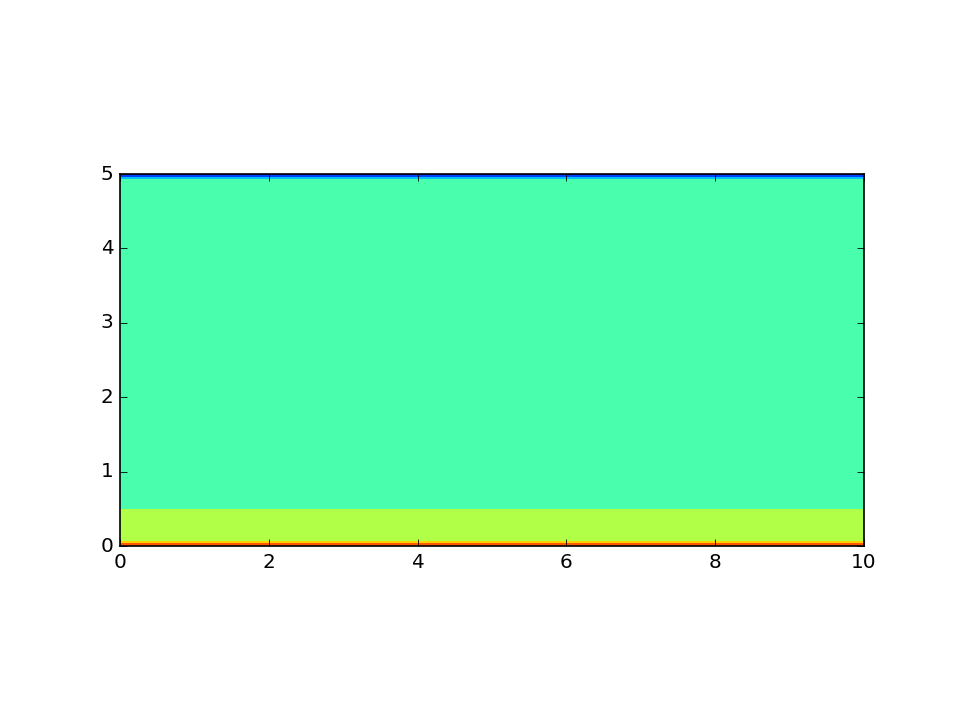

In [40]:
f1 = pl.figure(dpi=120)
ax = pl.axes(xlim=(0,10),ylim=(0,5),aspect='equal')


images = AnimStep(50,T_o,0.,Dx,Dy,Dt,T_bottom,T_top,Nx,Ny)

im_ani = anim.ArtistAnimation(f1, images, interval=25, repeat_delay=900,blit=False)

In [18]:
images

[(<matplotlib.collections.QuadMesh at 0x1b71eb01320>,),
 (<matplotlib.collections.QuadMesh at 0x1b71eb01a90>,),
 (<matplotlib.collections.QuadMesh at 0x1b71ba2b358>,),
 (<matplotlib.collections.QuadMesh at 0x1b71ba2b278>,),
 (<matplotlib.collections.QuadMesh at 0x1b71ba11198>,),
 (<matplotlib.collections.QuadMesh at 0x1b71ba11a58>,),
 (<matplotlib.collections.QuadMesh at 0x1b71ba14358>,),
 (<matplotlib.collections.QuadMesh at 0x1b71ba14c18>,),
 (<matplotlib.collections.QuadMesh at 0x1b71ba14438>,),
 (<matplotlib.collections.QuadMesh at 0x1b71ba16518>,)]